# Home

In [1]:
from google.colab import drive
import pandas as pd
import os

drive.mount('/content/gdrive')
root_dir = '/content/gdrive/MyDrive/HomeCredit/'
pid = 'SK_ID_CURR'
sid1 = 'SK_ID_BUREAU'
sid2 = 'SK_ID_PREV'
id_columns = [pid, sid1, sid2]
target = 'TARGET'
os.chdir(root_dir)
import eda as eda
import machine_learning as ml
import joblib
applications_csv = 'csv/applications.csv'
agg_dir = root_dir + 'csv/aggregated/'
from importlib import reload
import hypothesis as hypothesis
import numpy as np
!pip install shap -q
import shap


base_params = {
    'objective': 'binary',
    'metric': 'auc',
    'force_row_wise':'true',
    'is_unbalance': True,
    'early_stopping_rounds': 10,
    'verbose':-1
}

Mounted at /content/gdrive


In [370]:
num_selected = pd.read_csv('csv/app_num_slct.csv')
app_t = pd.read_csv(applications_csv, usecols=['SK_ID_CURR',target])
df = pd.read_csv(applications_csv)
eda.convert_to_bool(df)

## Select features

In [190]:
num = df.select_dtypes(include=['number'])
corr_matrix = num.corr()
num[target] = df[target]
clf = ml.classifier(num, base_params,target, 'num_applications')
clf = joblib.load('classifiers/num_applications.pkl')
feature_importance = ml.feature_importance(clf)
corr_features = eda.corr_features(
    corr_matrix,0.9).sort_values(by='Correlation')
selected = ml.selected_features(corr_features,
                            feature_importance,0.9,2)
num_selected = num[selected].drop(columns=['EXT_SOURCE_1','EXT_SOURCE_2',
                            'EXT_SOURCE_3'])

## Numerical

In [372]:
num_selected = pd.read_csv('csv/app_num_slct.csv')
app = pd.read_csv(applications_csv, usecols=[pid,target])
num_selected_t = num_selected.merge(app[[pid,target]], on = pid)

In [199]:
num_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DAYS_BIRTH                    307511 non-null  int64  
 1   AMT_ANNUITY                   307499 non-null  float64
 2   AMT_CREDIT                    307511 non-null  float64
 3   DAYS_EMPLOYED                 307511 non-null  int64  
 4   DAYS_ID_PUBLISH               307511 non-null  int64  
 5   OWN_CAR_AGE                   104582 non-null  float64
 6   DAYS_LAST_PHONE_CHANGE        307510 non-null  float64
 7   DAYS_REGISTRATION             307511 non-null  float64
 8   REGION_POPULATION_RELATIVE    307511 non-null  float64
 9   SK_ID_CURR                    307511 non-null  int64  
 10  AMT_INCOME_TOTAL              307511 non-null  float64
 11  AMT_REQ_CREDIT_BUREAU_YEAR    265992 non-null  float64
 12  LANDAREA_MODE                 124921 non-nul

## Downsampling

In [308]:
num_selected_t[num_selected_t['DAYS_EMPLOYED'] == 365243][target].value_counts()

False    52384
True      2990
Name: TARGET, dtype: int64

In [203]:
num_selected_t_no_nan = eda.remove_nan(num_selected_t)

In [205]:
clf = ml.classifier(num_selected_t_no_nan, base_params,target,
                    'train_applications_num_no_nan')

0.6553654938415974


In [206]:
columns = ml.feature_importance(clf)['Feature'][:5]
df = num_selected_t_no_nan[columns].copy()
df = df.round(-2)
df[target] = num_selected_t_no_nan[target]
cols = list(df.columns)
last_col = cols[-1]
new_cols = [last_col] + cols[:-1]
df = df[new_cols]
df = df.sort_values(by=df.columns.tolist())

df_0 = df[df[target] == 0]
df_1 = df[df[target] == 1]
df_0['strata'] = range(len(df_0))

downsampled_df_0 = df_0[df_0['strata'] % 12 == 0]
downsampled_df_0 = downsampled_df_0.drop(columns=['strata'])
df=pd.concat([df_1,downsampled_df_0])


In [269]:
df.to_csv('csv/downsampled_idex.csv', columns=[])

## Numerical univariant plots

AMT_CREDIT


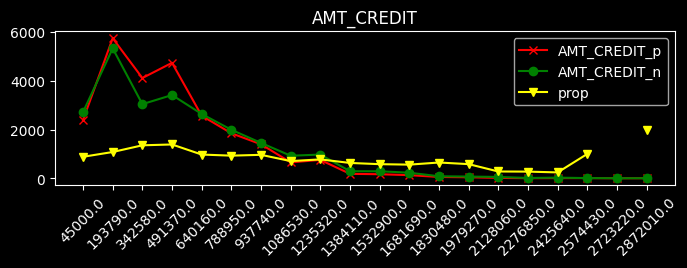

middle 3107
higher 3
lower 0
-------------------------------------------



AMT_ANNUITY


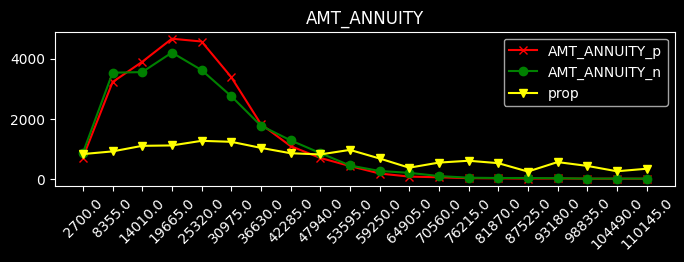

middle 853
higher 20
lower 0
-------------------------------------------



DAYS_ID_PUBLISH


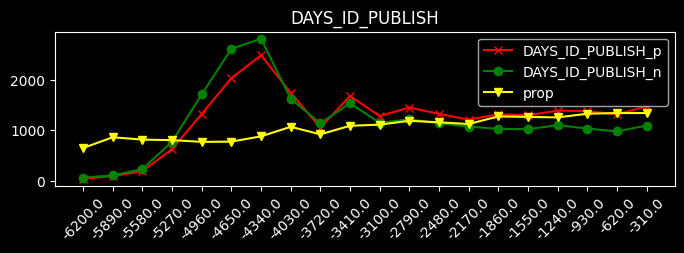

middle 63
higher 0
lower 0
-------------------------------------------



DAYS_EMPLOYED


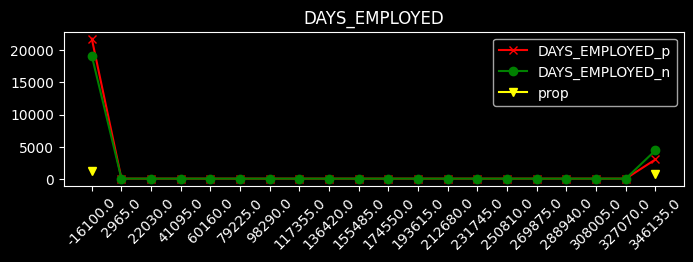

middle 159
higher 0
lower 0
-------------------------------------------



DAYS_BIRTH


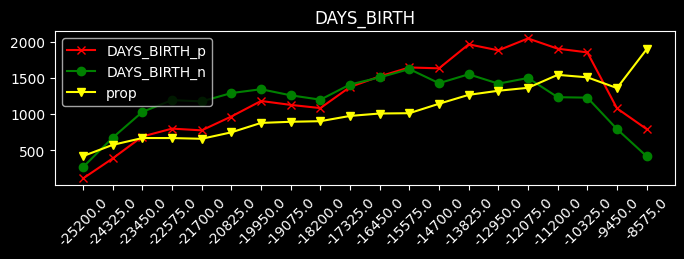

middle 176
higher 0
lower 0
-------------------------------------------





In [217]:
eda.num_eda(df,target,10e+2,20)

## SHAP analysis

In [351]:
df = num_selected_t[num_selected_t.index.isin(df.index)]

In [219]:
clf = ml.classifier(df, base_params,target,'sample_applications')

0.6638608265453826


In [220]:
X, y, X_test, y_test = ml.train_val_split(df, target)

In [221]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

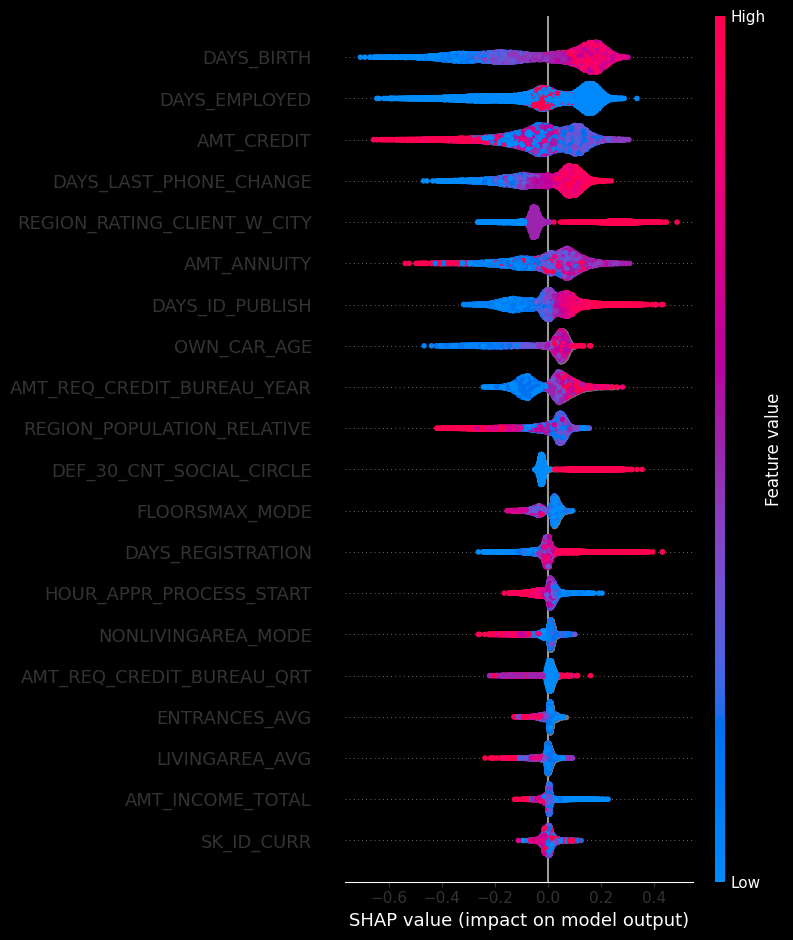

In [222]:
shap.summary_plot(shap_values, X)

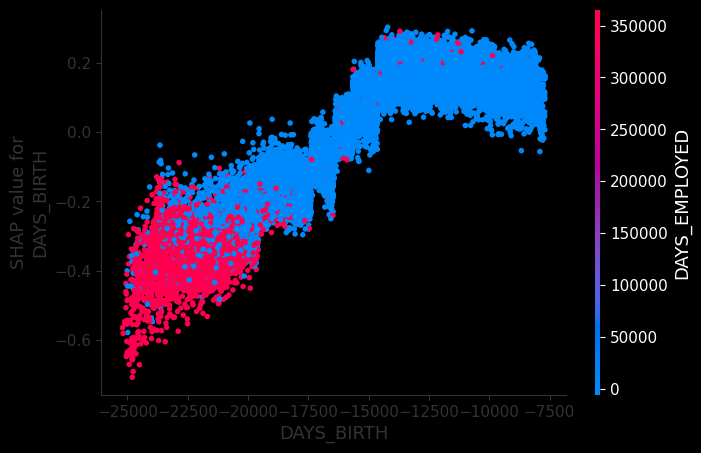

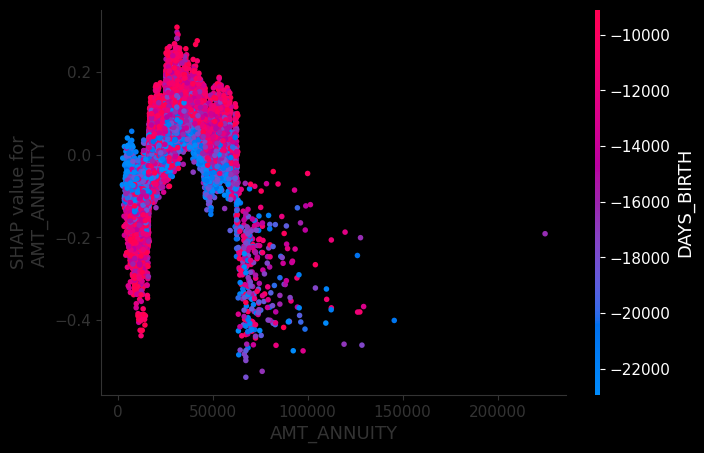

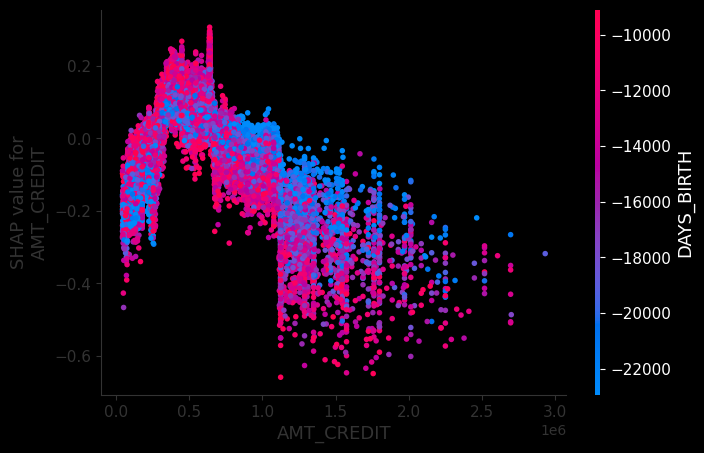

In [449]:
for name in X.columns[:3]:
    shap.dependence_plot(name, shap_values.values, X, display_features=X)

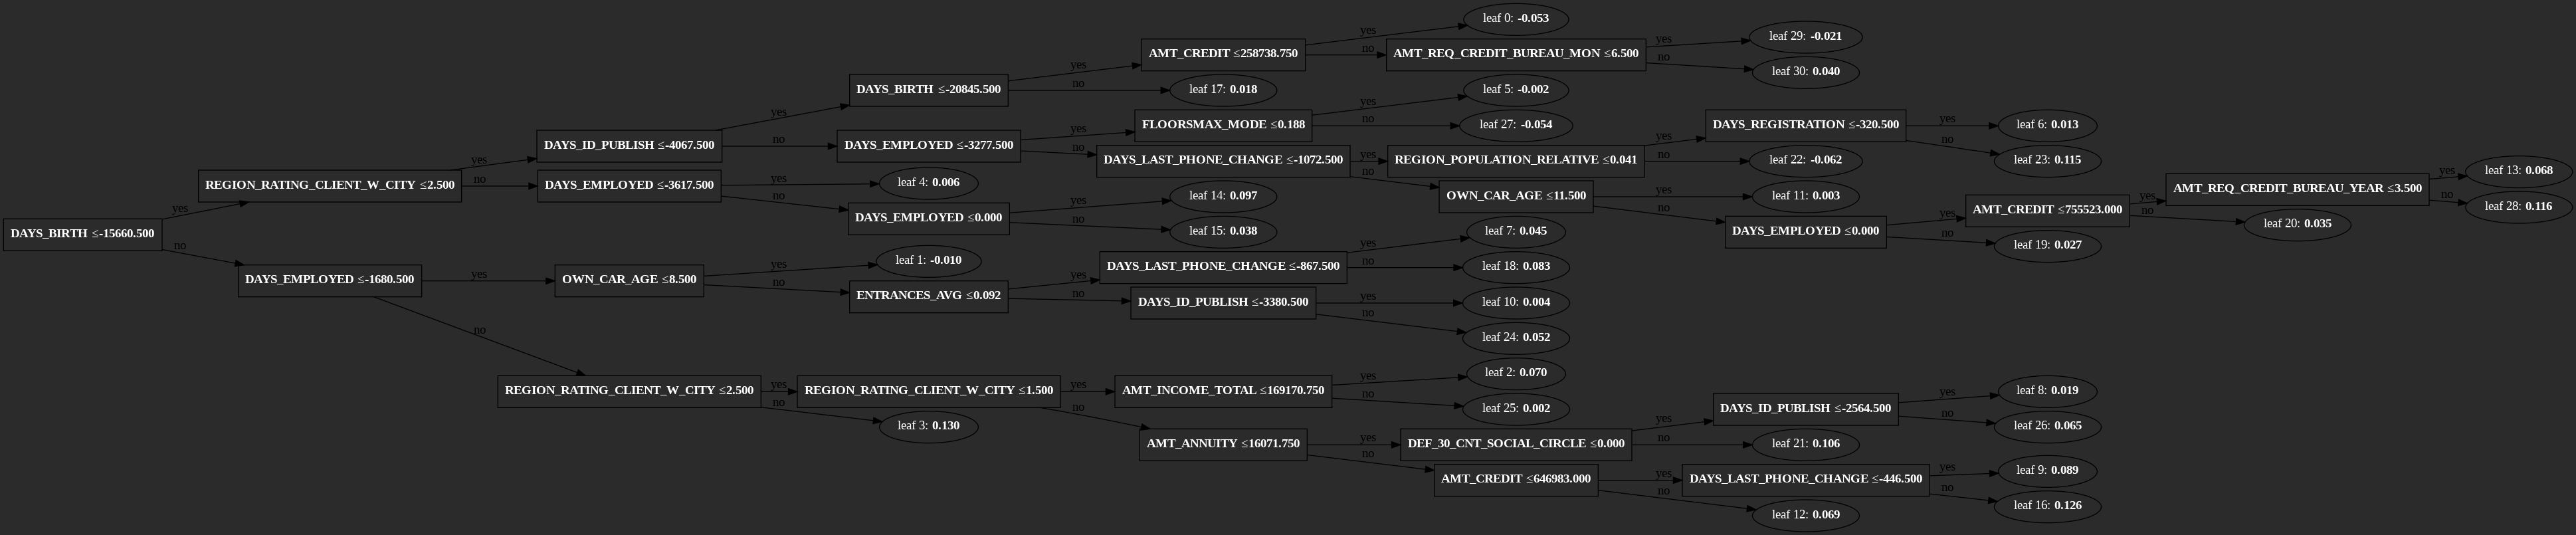

In [302]:
ml.graph_tree(clf,[0])

## Categorical

In [ ]:
app_df = pd.read_csv(applications_csv)

In [300]:
cols = ml.feature_importance(clf)['Feature'][:40].tolist()
cols.append(target)
df = app_df[cols]

n_unique_values = df.nunique()
low_cardinality_cols = n_unique_values[n_unique_values < 30].index

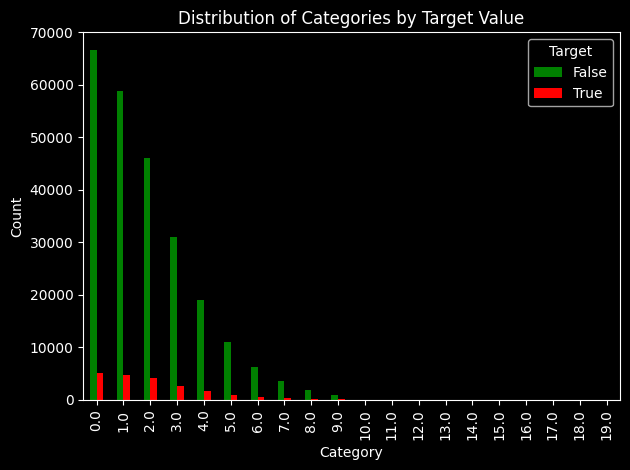

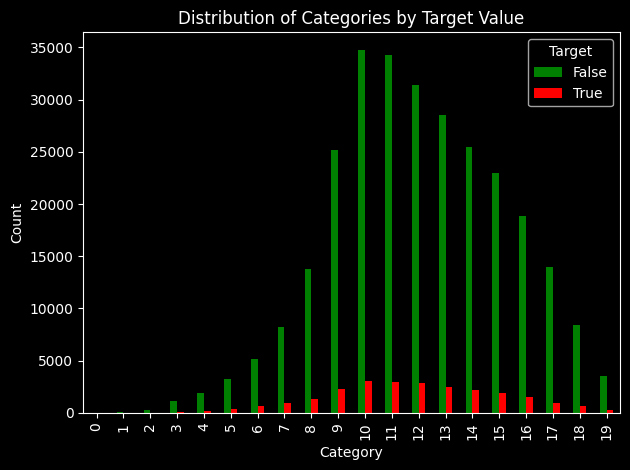

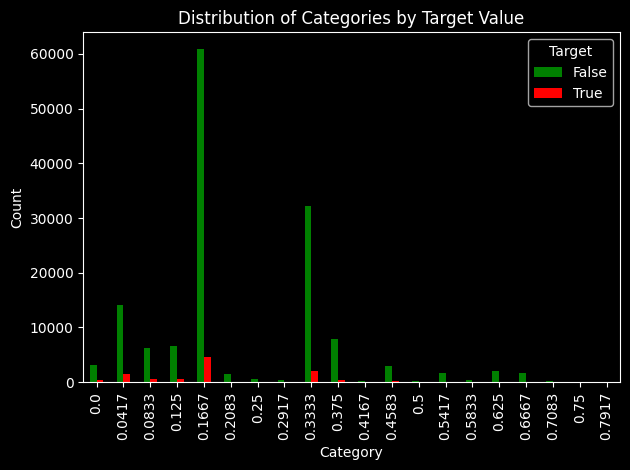

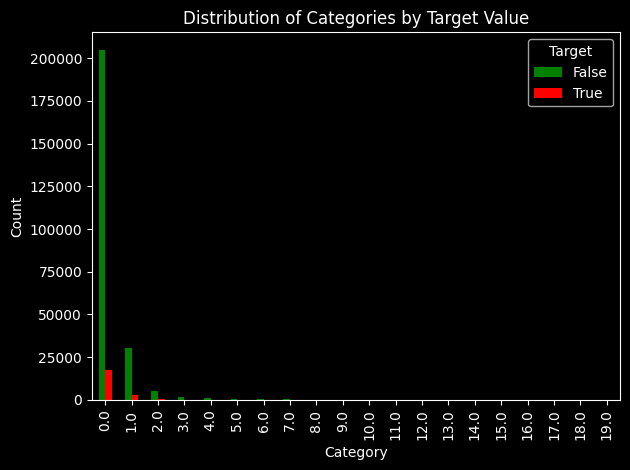

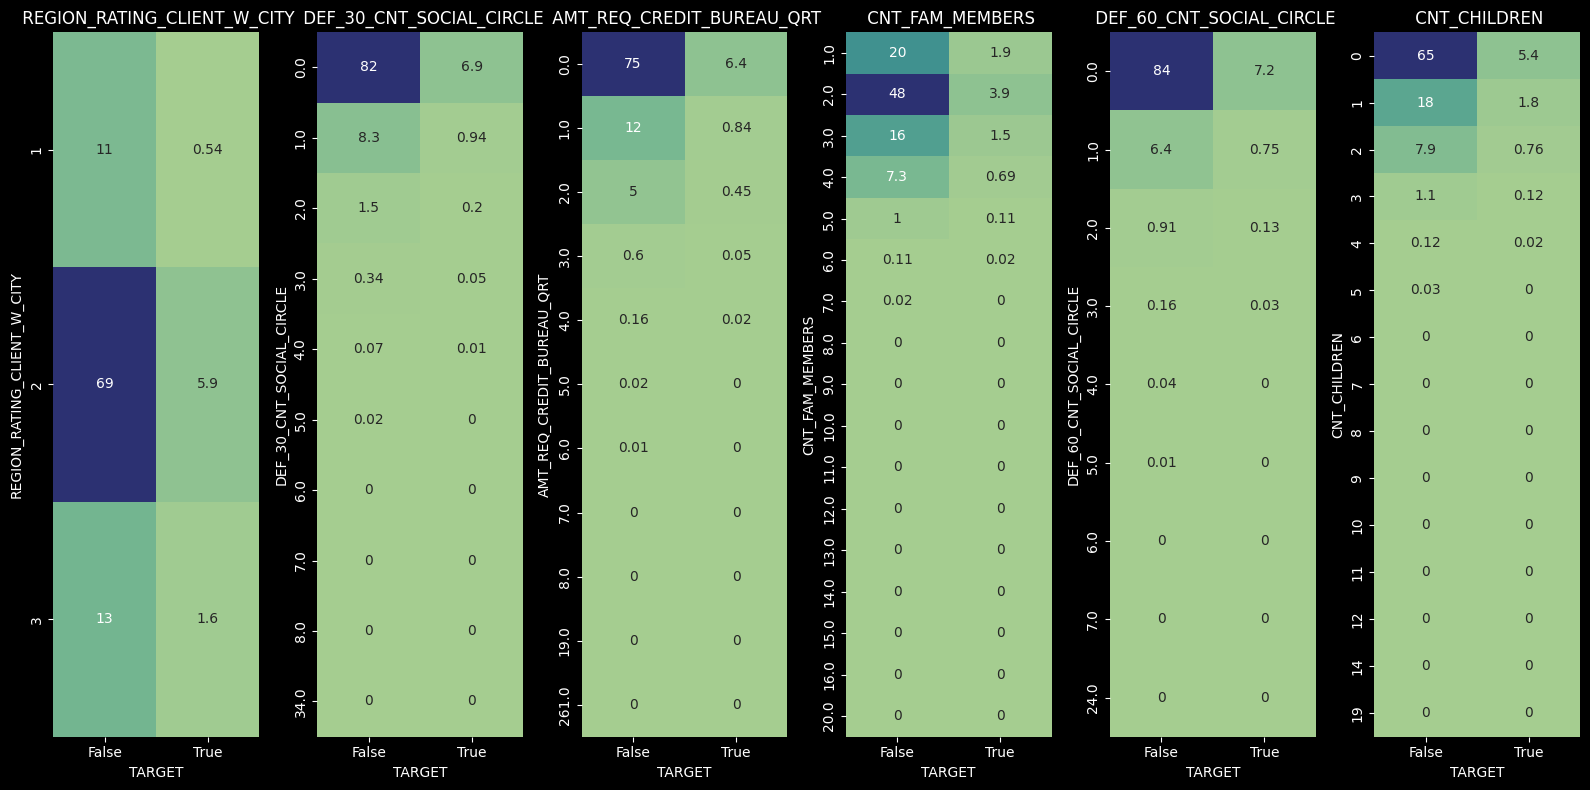

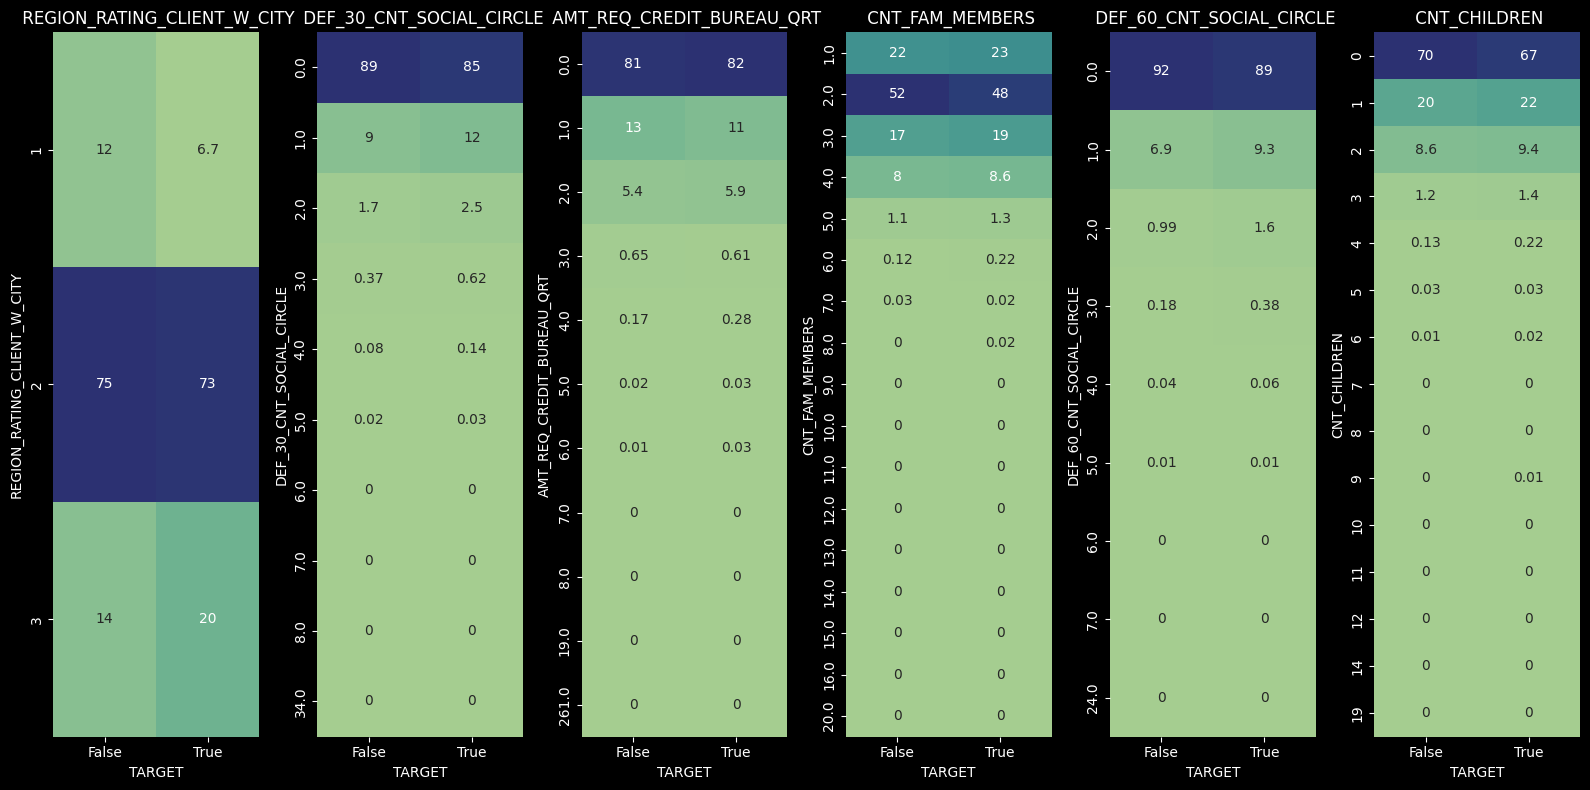

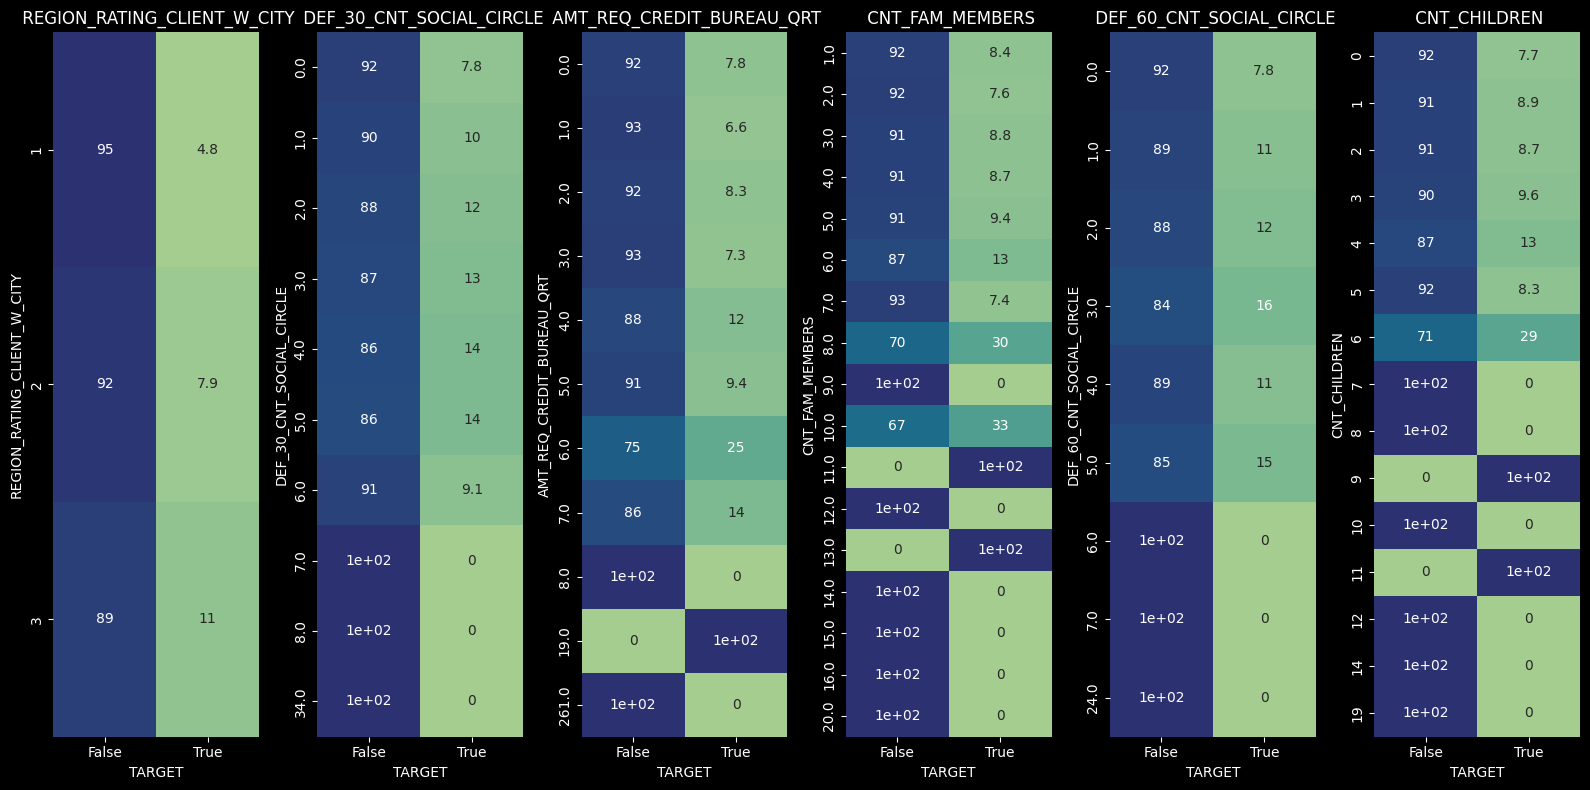

In [301]:
eda.plot_columns(df[low_cardinality_cols],target)

## Multivariant analysis

In [434]:
num_selected = pd.read_csv('csv/app_num_slct.csv')
index = pd.read_csv('csv/downsampled_index.csv')
df = num_selected[num_selected.index.isin(index['Unnamed: 0'])].copy()
app_t = pd.read_csv(applications_csv, usecols=['SK_ID_CURR',target])
df = eda.add_target(df,app_t,pid,target)

In [448]:
columns = ['AMT_ANNUITY', 'AMT_CREDIT']
filtered_df = eda.drop_outliers(df.copy(),columns)
eda.plot_round(filtered_df,columns, target,False,800,1200)

83
1529
221
24
